This exercise contains tasks about processing ECG (Electrocardiography) signal. The input excel file (samples.csv) has 3 columns: "Time" is for the timestamp of the recording, "ECG_I_Unfiltered" is for the raw ECG recording, "ECG_I_Filtered" contains the filtered recording (done by the authors of the dataset). Each row corresponds to a recording.

### Task 1
Plot the unfiltered and filtered signal into the same graph to compare them.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import neurokit2 as nk


Shape of the data is (10000, 3)


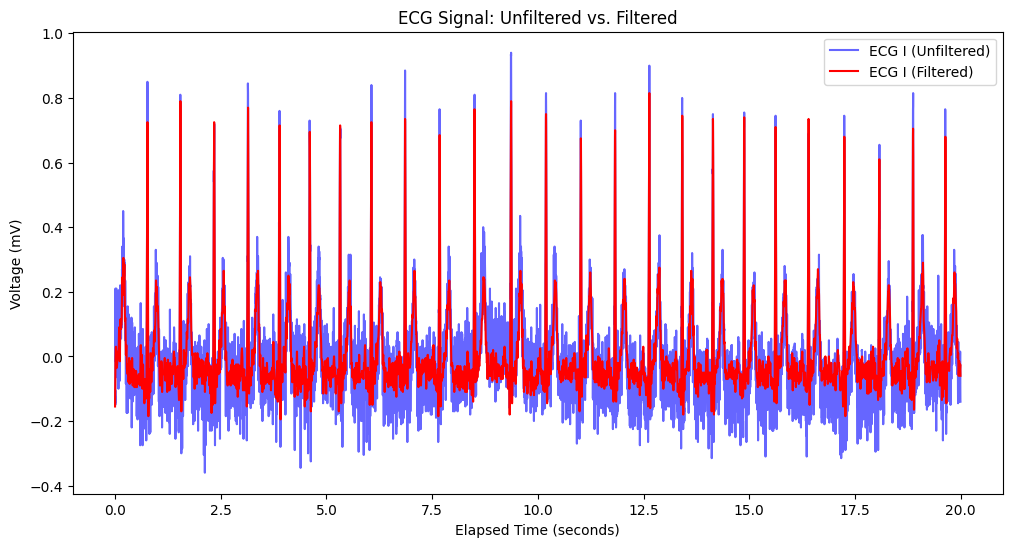

In [38]:
fs = 500 # Sampling rate

# read the samples file, skil the first row 
df = pd.read_csv('samples.csv', header=None, skiprows=1) 

df.columns = ['Time', 'ECG_I_Unfiltered', 'ECG_I_Filtered']

# Drop the unit row
df = df.iloc[1:].copy()
print(f"Shape of the data is {df.shape}") # Checking the shape, it should be (10000x3)

# Remove any surrounding quotes from the time column
df['Time'] = df['Time'].astype(str).str.strip("'")

# Ensure that the values in the ECG columns are numeric 
df['ECG_I_Unfiltered'] = pd.to_numeric(df['ECG_I_Unfiltered'], errors='coerce')
df['ECG_I_Filtered'] = pd.to_numeric(df['ECG_I_Filtered'], errors='coerce')

# Drop any rows that failed to convert to a number
df = df.dropna(subset=['ECG_I_Unfiltered', 'ECG_I_Filtered'])

# Function to convert 'hh:mm:ss.mmm' to total seconds
def time_to_seconds(time_str):
    try:
        parts = time_str.split(':')
        if len(parts) == 3: # hh:mm:ss.mmm
            h, m, s_ms = parts
        elif len(parts) == 2: # mm:ss.mmm, it seems that all time values in the file are this type
            h = '0'
            m, s_ms = parts
        else:
            return None

        minutes = int(m)
        seconds, milliseconds_str = s_ms.split('.')
        seconds = int(seconds)
        milliseconds = int(milliseconds_str) / 1000
        return int(h) * 3600 + minutes * 60 + seconds + milliseconds
    except:
        return None

df['Time_s'] = df['Time'].apply(time_to_seconds)

# Drop any rows where time conversion failed
df = df.dropna(subset=['Time_s'])

# Plotting 
plt.figure(figsize=(12, 6))

# Plot the unfiltered signal
plt.plot(df['Time_s'], df['ECG_I_Unfiltered'],
         label='ECG I (Unfiltered)', color='blue', alpha = 0.6, linewidth=1.5)

# Plot the filtered signal
plt.plot(df['Time_s'], df['ECG_I_Filtered'],
         label='ECG I (Filtered)', color='red', linewidth=1.5)

plt.title('ECG Signal: Unfiltered vs. Filtered')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Voltage (mV)')
plt.legend(loc='upper right')
plt.show()

The unfiltered signal contains artefacts, so it appears thicker and "messier" than the filtered signal. The sources of the artefacts could be, for example, powerline interference (50/60 Hz), causing high-frequency noise, or poor skin-electrode contact, due to sweating or hair, causing low-frequency noise. Another source could be the moving (coughing, breathing) of the person, causing noise to chest-lead ECG.

### Task 2
Plot the power spectral density of raw and filtered ECG signal.

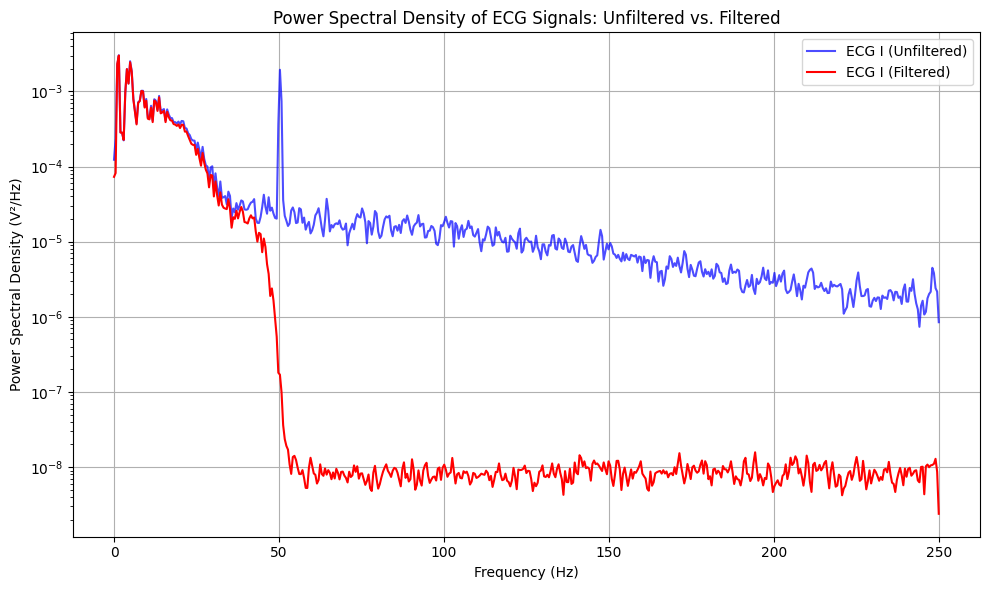

In [39]:
# Compute and plot Power Spectral Density (PSD) of raw and filtered ECG
plt.figure(figsize=(10, 6))

# Estimate PSD using Welch's method
f_raw, psd_raw = signal.welch(df['ECG_I_Unfiltered'], fs=fs, nperseg=1024)  
f_filt, psd_filt = signal.welch(df['ECG_I_Filtered'], fs=fs, nperseg=1024)

# Plot PSDs (y-axis is in logarithmic scale)
plt.semilogy(f_raw, psd_raw, label='ECG I (Unfiltered)', color='blue', alpha=0.7)
plt.semilogy(f_filt, psd_filt, label='ECG I (Filtered)', color='red')

plt.title('Power Spectral Density of ECG Signals: Unfiltered vs. Filtered')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The power spectral density tells us that the powers of the low-frequency range (0-40 Hz) of both raw and filtered signals are very similar. However, above this range, the powers of the frequency components in the raw signal are much greater (especially at 50 Hz) than those of the filtered signal. This shows that the low frequency content the true signal overlap with the low frequency noise (the unfiltered ECG has both low and high frequency noise components according to the data's description), while the high frequency noise components are very separated from the true signal. 

### Task 3
Try to detect P,Q,S,T peaks on the ECG waveforms.

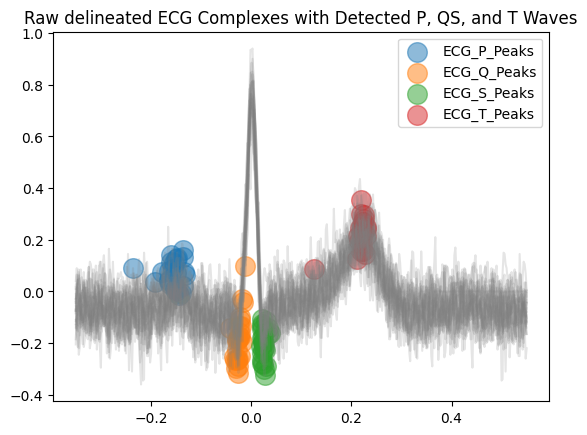

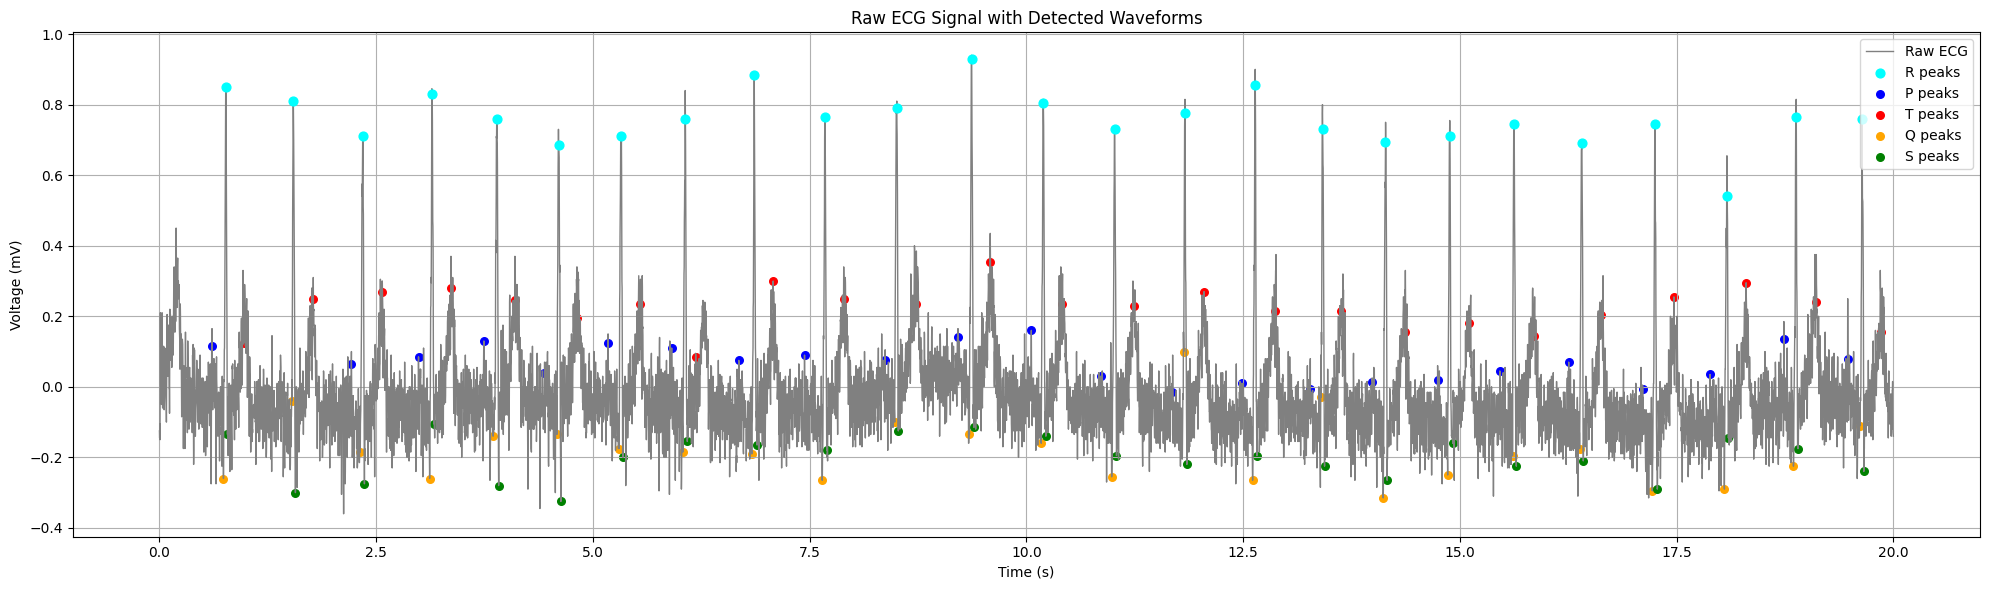

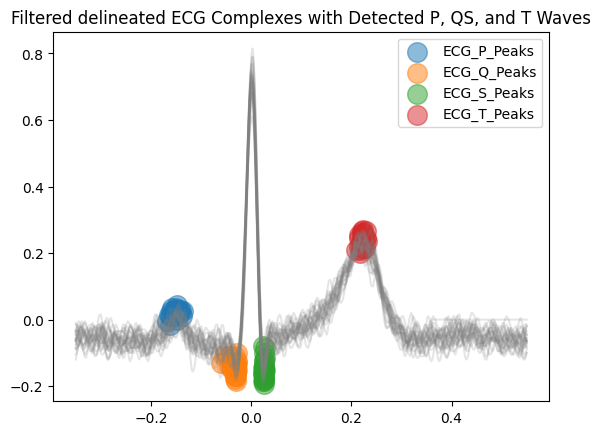

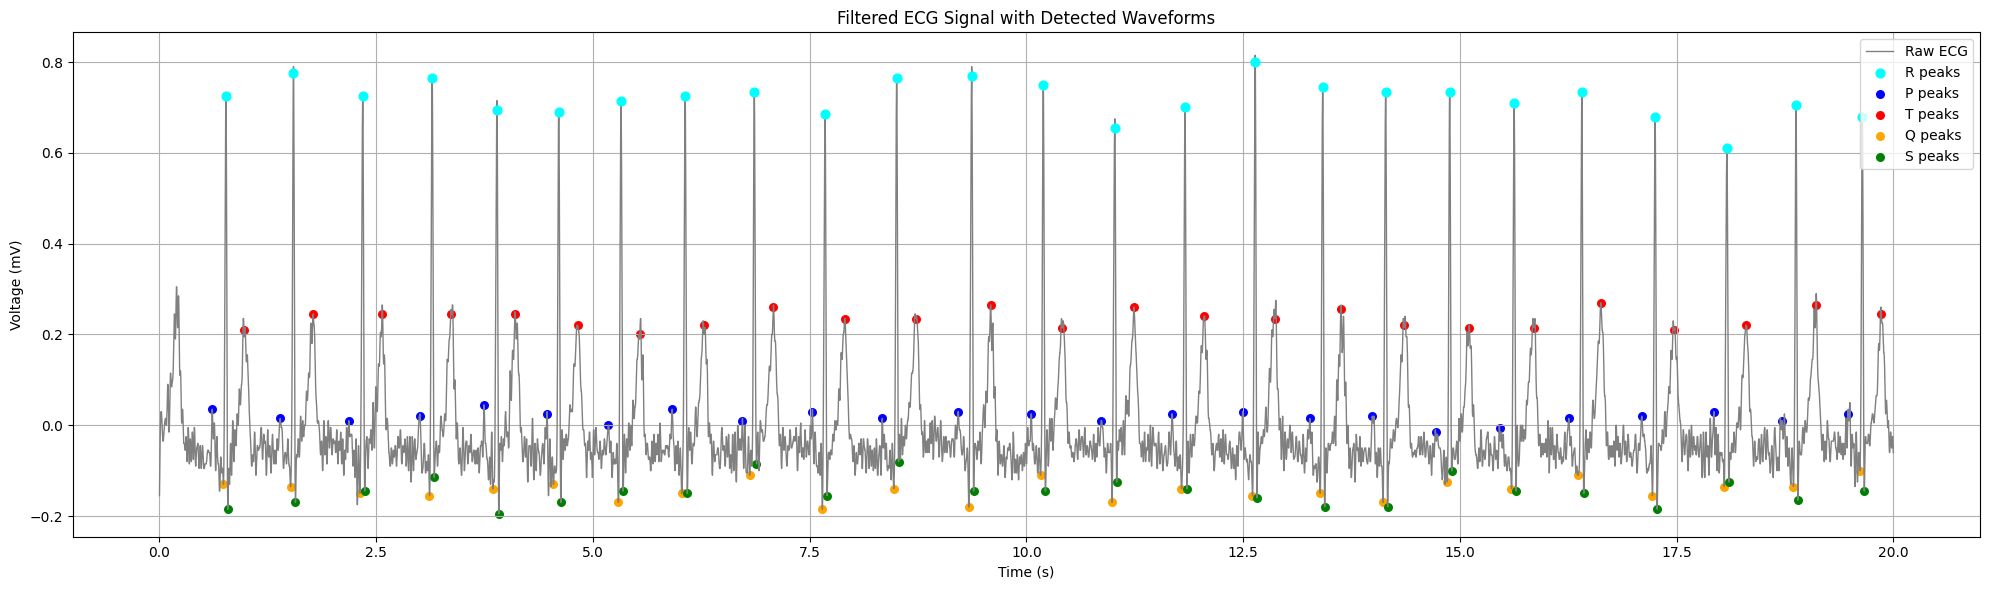

In [40]:
ecg_raw_signal = df['ECG_I_Unfiltered'].astype(float).values
ecg_filtered_signal = df['ECG_I_Filtered'].astype(float).values


def plot_ECG_with_detected_peaks(ecg_signal, signal_type):
    _, ecg_info = nk.ecg_process(ecg_signal, sampling_rate=fs) # Detect R-peaks

    # ECG delineation (detect P, Q, S, T)
    _, delineate_info = nk.ecg_delineate(
        ecg_signal,
        rpeaks=ecg_info['ECG_R_Peaks'], # ecg_info['ECG_R_Peaks'] gives the indices of R-peaks
        sampling_rate=fs,
        method="dwt",
        show=True, 
        show_type='peaks'
    )
    # Add a custom title to the generated plot
    if signal_type == "raw":
        plt.title("Raw delineated ECG Complexes with Detected P, QS, and T Waves")
        plt.show()
    else:
        plt.title("Filtered delineated ECG Complexes with Detected P, QS, and T Waves")
        plt.show()

    # Plot raw ECG with detected peaks 
    plt.figure(figsize=(20, 6))
    plt.plot(df['Time_s'], ecg_signal, label='Raw ECG', color='gray', linewidth=1)

    # Plot detected waves. plt.scatter() draws dots on the plot
    plt.scatter(df['Time_s'].iloc[ecg_info['ECG_R_Peaks']], ecg_signal[ecg_info['ECG_R_Peaks']],
                color='cyan', label='R peaks', s=40, zorder=3)
    plt.scatter(df['Time_s'].iloc[delineate_info['ECG_P_Peaks']], ecg_signal[delineate_info['ECG_P_Peaks']],
                color='blue', label='P peaks', s=30)
    plt.scatter(df['Time_s'].iloc[delineate_info['ECG_T_Peaks']], ecg_signal[delineate_info['ECG_T_Peaks']],
                color='red', label='T peaks', s=30)
    plt.scatter(df['Time_s'].iloc[delineate_info['ECG_Q_Peaks']], ecg_signal[delineate_info['ECG_Q_Peaks']],
                color='orange', label='Q peaks', s=30)
    plt.scatter(df['Time_s'].iloc[delineate_info['ECG_S_Peaks']], ecg_signal[delineate_info['ECG_S_Peaks']],
                color='green', label='S peaks', s=30)

    if signal_type == "raw":
        plt.title("Raw ECG Signal with Detected Waveforms")
    else:
        plt.title("Filtered ECG Signal with Detected Waveforms")

    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ECG_with_detected_peaks(ecg_raw_signal, "raw")
plot_ECG_with_detected_peaks(ecg_filtered_signal,"")

The algorithm apperently doesn't work well in detecting the P, Q, and S peaks for the unfiltered data. This is due to the fact that the unfiltered data is too thick and messy, compromised by noise, while these peaks have small magnitude. Hence, they are easily blended in with other measurements. On the other hand, the R peaks and T peaks are pretty easily to detect, since they have large magnitudes, easily standing out in a cycle.

### Task 4
Build a simple set of filters and apply them to the unfiltered signal.

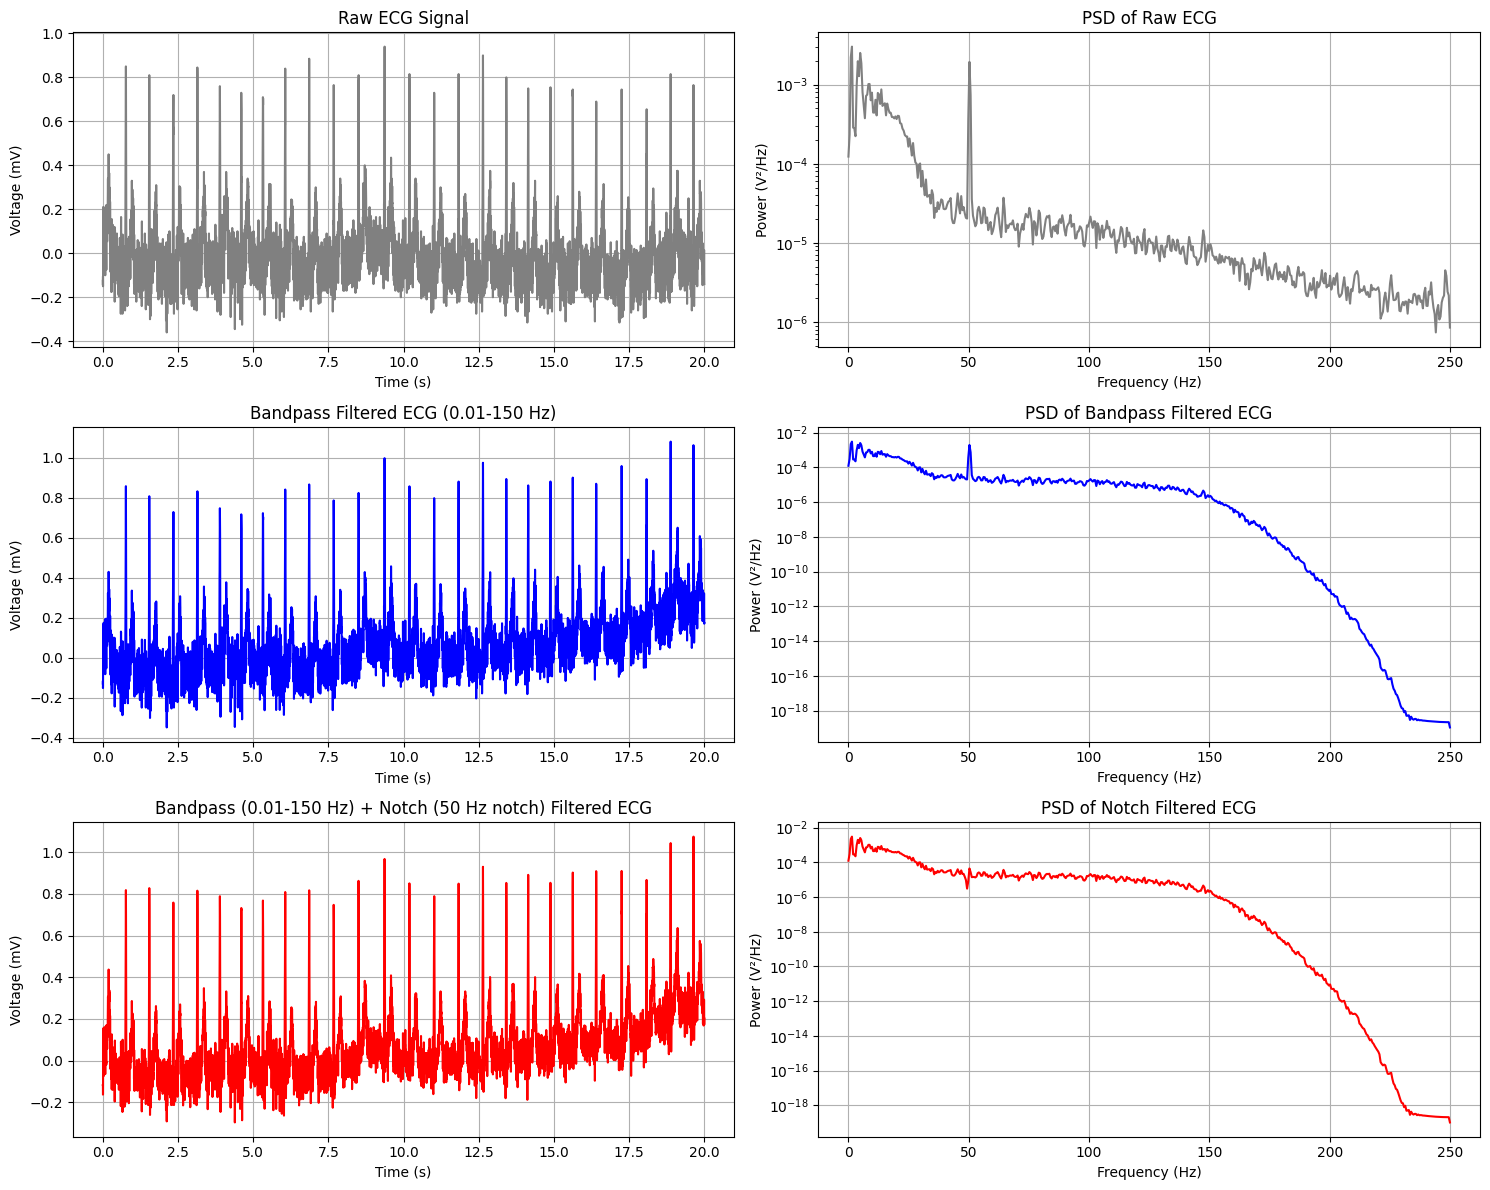

In [41]:
# Bandpass filter 0.01 - 150 Hz ---
bp_low = 0.01
bp_high = 150
bp_order = 4 # Order of the filter. High = Sharp cutoff, low = less steep

# Design Butterworth bandpass filter
b_bp, a_bp = signal.butter(bp_order, [bp_low/(fs/2), bp_high/(fs/2)], btype='band')
ecg_bp = signal.filtfilt(b_bp, a_bp, ecg_raw_signal)

# PSD for bandpass filtered signal
f_bp, psd_bp = signal.welch(ecg_bp, fs=fs, nperseg=1024)

# Notch filter at 50 Hz 
notch_freq = 50.0 
quality_factor = 30.0 # Measure how narrow or wide the notch is. High = narrow, low = wide

b_notch, a_notch = signal.iirnotch(notch_freq/(fs/2), quality_factor)
ecg_filtered = signal.filtfilt(b_notch, a_notch, ecg_bp)

# PSD for notch filtered signal
f_notch, psd_notch = signal.welch(ecg_filtered, fs=fs, nperseg=1024)

# Plotting all in subplots 
plt.figure(figsize=(15, 12))

# Raw
plt.subplot(3, 2, 1)
plt.plot(df['Time_s'], ecg_raw_signal, color='gray')
plt.title("Raw ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.grid(True)

plt.subplot(3, 2, 2)
plt.semilogy(f_raw, psd_raw, color='gray')
plt.title("PSD of Raw ECG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V²/Hz)")
plt.grid(True)

# Bandpass filtered
plt.subplot(3, 2, 3)
plt.plot(df['Time_s'], ecg_bp, color='blue')
plt.title("Bandpass Filtered ECG (0.01-150 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.grid(True)

plt.subplot(3, 2, 4)
plt.semilogy(f_bp, psd_bp, color='blue')
plt.title("PSD of Bandpass Filtered ECG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V²/Hz)")
plt.grid(True)

# Notch filtered
plt.subplot(3, 2, 5)
plt.plot(df['Time_s'], ecg_filtered, color='red')
plt.title("Bandpass (0.01-150 Hz) + Notch (50 Hz notch) Filtered ECG")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.grid(True)

plt.subplot(3, 2, 6)
plt.semilogy(f_notch, psd_notch, color='red')
plt.title("PSD of Notch Filtered ECG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V²/Hz)")
plt.grid(True)

plt.tight_layout()
plt.show()


The bandpass filter for 0.01 - 150 Hz attenuates the frequencies outside of this range. The 50 Hz notch filter attenuates the power of the frequency component at 50 Hz. Just by visual inspection, the filtered versions honestly don't look so much differently compared to the raw signal in my opinion. The bandpass + notch filtered one does look cleaner and less thick than the raw signal, but this can only be detected after meticulous observation. Some other possible improvements regarding the filters could be to use a tighter bandpass (0.5 - 40 Hz), or increase the order of the bandpass filter to achieve a sharper cutoff.